# Power - Demand and Consumption

In this Ipython notebook, we are going to analyze electricity consumption data from a house. We have a  time-series dataset which contains the power(kWh), Cost of electricity and Voltage at a particular time stamp. We are further provided with the temperature records during the same day for each hour.

First part is the Data Analysis Part where we will be doing the basic data cleaning and analysis regarding the power demand and cost incurred. The second part employs a KMeans clustering approach to identify which appliance might be the major cause for the power demand in a particular hour of the day.

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [272]:
# Read the sensor dataset into pandas dataframe
sensor_data = pd.read_csv('merged-sensor-files.csv',
                          names=["MTU", "Time", "Power", "Cost", "Voltage"], header = False)

# Read the weather data in pandas series object
weather_data = pd.read_json('weather.json', typ ='series')

In [273]:
# A quick look at the datasets
sensor_data.head(5)

,MTU,Time,Power,Cost,Voltage
0,MTU1,05/11/2015 19:59:06,4.102,0.62,122.4
1,MTU1,05/11/2015 19:59:05,4.089,0.62,122.3
2,MTU1,05/11/2015 19:59:04,4.089,0.62,122.3
3,MTU1,05/11/2015 19:59:06,4.089,0.62,122.3
4,MTU1,05/11/2015 19:59:04,4.097,0.62,122.4


In [274]:
weather_data

2015-05-12 00:00:00    75.4
2015-05-12 01:00:00    73.2
2015-05-12 02:00:00    72.1
2015-05-12 03:00:00    71.0
2015-05-12 04:00:00    70.7
2015-05-12 05:00:00    69.6
2015-05-12 06:00:00    69.0
2015-05-12 07:00:00    68.8
2015-05-12 08:00:00    69.2
2015-05-12 09:00:00    67.9
2015-05-12 10:00:00    68.6
2015-05-12 11:00:00    68.7
2015-05-12 12:00:00    72.1
2015-05-12 13:00:00    76.2
2015-05-12 14:00:00    80.1
2015-05-12 15:00:00    80.7
2015-05-12 16:00:00    80.9
2015-05-12 17:00:00    83.3
2015-05-12 18:00:00    84.5
2015-05-12 19:00:00    85.1
2015-05-12 20:00:00    87.0
2015-05-12 21:00:00    84.2
2015-05-12 22:00:00    84.4
2015-05-12 23:00:00    83.0
2015-05-13 00:00:00    81.1
dtype: float64

# TASK 1: Data Analysis

### Data Cleaning/Munging:
After having a look at the <b>merged-sensor-files.csv</b> I found out there are some inconsistent rows where header names are repeated and as a result 'pandas' is converting all these columns to 'object' type.

In [275]:
sensor_data.dtypes

MTU        object
Time       object
Power      object
Cost       object
Voltage    object
dtype: object

Let's find out and remove these inconsistent rows so that all the columns can be converted to appropriated data types. 

In [276]:
# Get the inconsistent rows indexes
faulty_row_idx = sensor_data[sensor_data["Power"] == " Power"].index.tolist()
faulty_row_idx

[3784,
 7582,
 11385,
 15004,
 18773,
 22363,
 26049,
 29795,
 33554,
 37193,
 40951,
 44563,
 48227,
 51934,
 55660,
 59431,
 63041,
 66706,
 70468,
 74305,
 77951,
 81617,
 85327]

In [277]:
# Drop these rows from sensor_data dataframe
sensor_data.drop(faulty_row_idx, inplace=True)

# This should return an empty list now
sensor_data[sensor_data["Power"] == " Power"].index.tolist()

[]

We have cleaned up the sensor_data and now these can be converted to more appropriate data types.

In [278]:
# Type Conversion
sensor_data[["Power", "Cost", "Voltage"]] = sensor_data[["Power", "Cost", "Voltage"]].astype(float)
sensor_data[["Time"]] = pd.to_datetime(sensor_data["Time"])

# Also add an 'Hour' column in sensor_data
sensor_data['Hour'] = pd.DatetimeIndex(sensor_data["Time"]).hour

sensor_data.dtypes

MTU                object
Time       datetime64[ns]
Power             float64
Cost              float64
Voltage           float64
Hour                int32
dtype: object

This is better now. We have got clearly defined datatypes of different columns now. Next step is to convert the weather_data Series to a dataframe so that we can work with it with more ease.

In [279]:
# Create a dataframe out of weather dataset as well
temperature_data = weather_data.to_frame()

# Reindex it so as to create a two column dataframe
temperature_data.reset_index(level=0, inplace=True)
temperature_data.columns = ["Time", "Temperature"]

# Add the "Hour" column in temperature_data
temperature_data["Hour"] = pd.DatetimeIndex(temperature_data["Time"]).hour

temperature_data.dtypes

Time           datetime64[ns]
Temperature           float64
Hour                    int32
dtype: object

Since now we have both of our dataframes in place, it'd be a good point to have a look at sum of the basic statistics of both of these data frames.

In [280]:
sensor_data.describe()

,Power,Cost,Voltage,Hour
count,88891.000000,88891.000000,88891.000000,88891.000000
mean,1.315980,0.202427,123.127744,11.531865
std,1.682181,0.252357,0.838768,6.921671
min,0.113000,0.020000,121.000000,0.000000
25%,0.255000,0.040000,122.600000,6.000000
50%,0.367000,0.060000,123.100000,12.000000
75%,1.765000,0.270000,123.700000,18.000000
max,6.547000,0.990000,125.600000,23.000000


In [281]:
temperature_data.describe()

,Temperature,Hour
count,25.000000,25.00000
mean,76.272000,11.04000
std,6.635355,7.29429
min,67.900000,0.00000
25%,69.600000,5.00000
50%,75.400000,11.00000
75%,83.000000,17.00000
max,87.000000,23.00000


As apparent from above statistics there is a good amount of variation in <b>Power</b> and corresponding <b>Cost</b> values in <b>sensor_data</b> dataframe, where average power is <b>1.315980kW</b> and minimum and maximum power used throughout the day is <b>0.11kW</b> and <b>6.54kW</b> respectively. Similarily there is an apparent variation in temperature in <b>temperature_data</b> dataset, most probably it attributes to day and night time. <br/><br/>
To get a better understanding of these variations we'll be plotting power and temperatures with the timestamps, so as to find out the peak times for both.<br><br>
But before moving to visualizations we'll have to create respective grouped datasets from <b>sensor_data</b> and <b>temperature_date</b>, grouping by the "Hour" column. This way we can work on hourly basis.

In [282]:
# Group sensor_data by 'Hour' Column
grouped_sensor_data = sensor_data.groupby(["Hour"], as_index = False).mean()
grouped_sensor_data

,Hour,Power,Cost,Voltage
0,0,0.173790,0.029468,124.723879
1,1,0.179594,0.033805,124.522469
2,2,0.185763,0.037013,123.929979
3,3,0.184510,0.036815,124.174454
4,4,0.181104,0.036366,123.847801
5,5,0.184242,0.036693,122.790974
6,6,0.672423,0.106142,123.375132
7,7,0.977755,0.150614,123.722441
8,8,0.382392,0.060904,122.997544
9,9,0.168447,0.027770,122.675906


In [283]:
# Group temperature_data by "Hour"
grouped_temperature_data = temperature_data.groupby(["Hour"], as_index = False).mean()
grouped_temperature_data

,Hour,Temperature
0,0,78.25
1,1,73.20
2,2,72.10
3,3,71.00
4,4,70.70
5,5,69.60
6,6,69.00
7,7,68.80
8,8,69.20
9,9,67.90


## Basic Visualizations:

In [284]:
# Generates all the visualizations right inside the ipython notebook
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


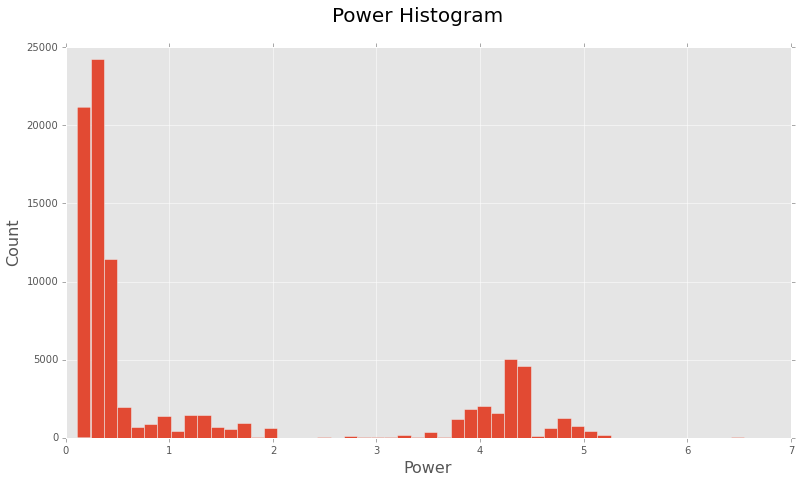

In [285]:
fig = plt.figure(figsize=(13,7))
plt.hist(sensor_data.Power, bins=50)
fig.suptitle('Power Histogram', fontsize = 20)
plt.xlabel('Power', fontsize = 16)
plt.ylabel('Count', fontsize = 16)

Looks like most of the time this house is consuming a limited amount of power. Although there is also a good amount of distribution in the range of <b>3.5kW - 5kW</b>, indicating a higher demand.<br/><br/>
Let's now plot the Power Distribution with the day hours.

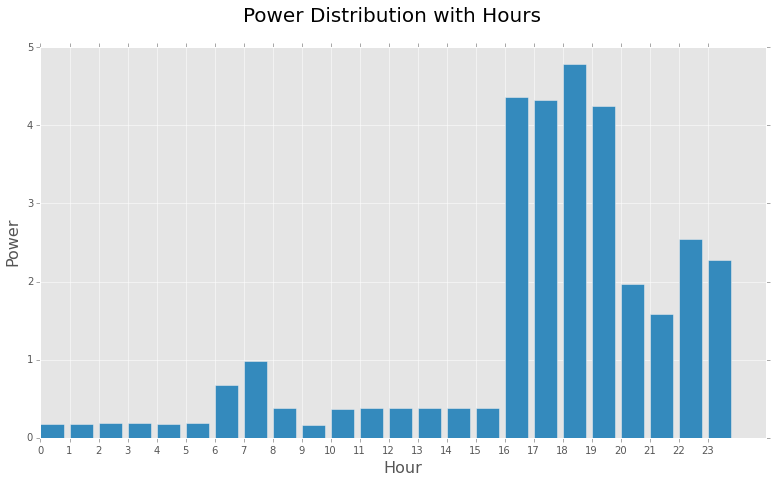

In [286]:
fig = plt.figure(figsize=(13,7))
plt.bar(grouped_sensor_data.Hour, grouped_sensor_data.Power)
fig.suptitle('Power Distribution with Hours', fontsize = 20)
plt.xlabel('Hour', fontsize = 16)
plt.ylabel('Power', fontsize = 16)
plt.xticks(range(0, 24))
plt.show()

#### Some of the inferences we can get from this bar chart are:

* Highest Demand is noticed during the evening hours. This is quite expected since most of the equipments would be in 'on' state during this time like AC(during summers), room heaters(during winters), TV, Oven, Washing Machine, Lights, etc.
* Night hours(0000 - 0500) and office hours(0900 - 1600) have very low demand, since most of the appliances will be in 'off' state during this period.
* There is a slight increase in Power during morning hours from 0600 - 0900, which should account for the power used by the appliances during morning activities, lights, geysers, etc.

#### Steady States:

* In the time period <b>0000 - 0500</b>, demand is noticeably less and ranges between <b>0.17kW - 0.18kW</b>
* Another steady period is from <b>1000 - 1500</b>, demand is pretty much steady between <b>0.373kW - 0.376kW</b>
* Steady state with highest demand is from <b>1600 - 1900</b> having a range between <b>4.36kW - 4.25kW</b>

Some sudden changes in Demand during 0700 and 1800 can be attributed because of random events or the usage of certain appliances and may be counted as noise in the dataset. 

Similarily there is a slight oscillation in demand during 0900 which suddenly falls down from 0.38kW to 0.16kW and rises up again to about 0.37kW. Similar change in demand is seen at 2100.

Let's further plot temperature with the Power to see if there is any correlation among these.

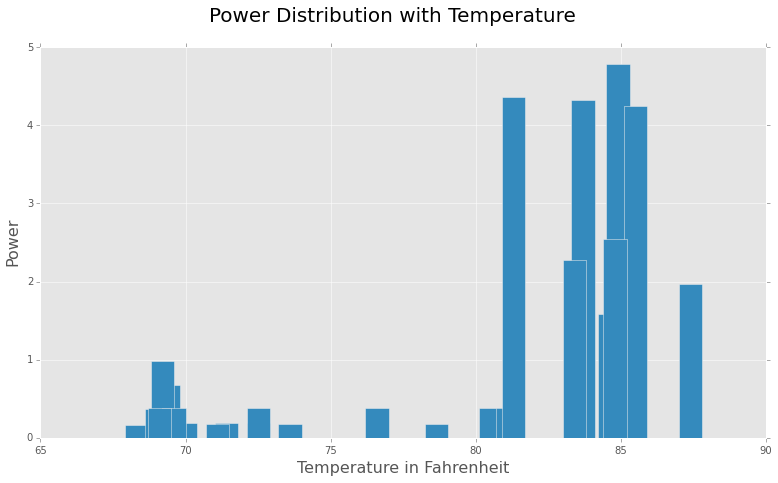

In [287]:
fig = plt.figure(figsize=(13,7))
plt.bar(grouped_temperature_data.Temperature, grouped_sensor_data.Power)
fig.suptitle('Power Distribution with Temperature', fontsize = 20)
plt.xlabel('Temperature in Fahrenheit', fontsize = 16)
plt.ylabel('Power', fontsize = 16)
plt.show()

There seems to be a direct correlation between temperature and the demand of power. This makes sense, since with our current dataset which is from May, this shows that cooling appliances like AC, refrigerator, etc. are consuming a lot of power during the peak hours(evening).

# Task 2: Machine Learning

We'll start with merging the <b>grouped_sensor_data</b> and <b>grouped_temperature_data</b> so that we can work on the complete dataset from a single dataframe.

In [291]:
# Merge grouped_sensor_data and grouped_temperature_data using "Hour" as the key
merged_data = grouped_sensor_data.merge(grouped_temperature_data)
merged_data

,Hour,Power,Cost,Voltage,Temperature
0,0,0.173790,0.029468,124.723879,78.25
1,1,0.179594,0.033805,124.522469,73.20
2,2,0.185763,0.037013,123.929979,72.10
3,3,0.184510,0.036815,124.174454,71.00
4,4,0.181104,0.036366,123.847801,70.70
5,5,0.184242,0.036693,122.790974,69.60
6,6,0.672423,0.106142,123.375132,69.00
7,7,0.977755,0.150614,123.722441,68.80
8,8,0.382392,0.060904,122.997544,69.20
9,9,0.168447,0.027770,122.675906,67.90


In previous visualization we saw that when temperature is low generally there is less demand of power. But that mainly relates to the cooling appliances in the home. We'll consider the following appliances:

* Cooling Systems
* TV
* Geyser
* Lights
* Oven
* Home Security Systems

and would try to identify there presence or on/off state using the merged dataset.<br>

#### AC, Refrigerator and Other Coooling Systems:
As apparent from "Power Distribution with Temperature" figure, there is a sudden increase in power demand with the rise in temperature. This clearly indicates the <b>ON</b> state of one or more cooling systems in the home. Since these appliances takes a considerable amount of power, this sudden upsurge in the power is quite justified. Clearly <b>Power</b> and <b>Temperature</b> are the two features that indicates the 'ON' state of these appliances. Although 'Cost' feature is also correlated with 'Power' we'd leave it out, since it is more of a causation of Power demand, then a completely independent feature.<br>

#### TV:
During the evening hours(1600 - 2300), an 'ON' television set is probably another factor for increased power demand. It is quite apparent from the <b>Power</b> feature.<br>

#### Geyser, Oven:
Slight increase in power demand during morning hours can be related to the presence of these appliances and is justified again by the <b>Power</b> feature.

#### Lights:
It's quite obvious there is a small contribution(considering house owner was smart and installed LED bulbs ;) ) of lights in the house in the 'Power' demand. And of course it only makes sense to switch 'ON' the lights during *darker times* :D of the day, <b>Hour</b> and Low <b>Power</b> are the indicators of lights.

#### Home Security Systems:
During the office hours there's a very little increase in the Power demand, this can be attributed to home security systems or other automated devices.<br><br>

Now, we'll be using simple <b>K-Means clustering</b> using <b>scikit-learn</b>. We are going to consider <b>Hour, Power and Temperature</b> feature from the original dataset. For that first of all we'll have to merge the sensor_data dataframe with grouped_temperature_data dataframe.

In [292]:
# Complete merged dataset
data =sensor_data.merge(grouped_temperature_data)

# Lets drop Time, MTU, Cost and Voltage features
data.drop(["Time", "MTU", "Cost", "Voltage"], axis = 1, inplace = True)
data.head()

,Power,Hour,Temperature
0,4.102,19,85.1
1,4.089,19,85.1
2,4.089,19,85.1
3,4.089,19,85.1
4,4.097,19,85.1


In [293]:
# Import required modules from scikit-learn
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split

In [294]:
# Set a random seed, so we can reproduce the results
np.random.seed(1234)

# Divide the merged dataset into train and test datasets
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 42)

In [295]:
# We are left with train and test sets of dimensions
train_data.shape

(66668, 3)

In [296]:
test_data.shape

(22223, 3)

In [297]:
# Perform K-Means clustering over the train dataset
kmeans = KMeans(n_clusters = 4, n_jobs = 4)
kmeans_fit = kmeans.fit(train_data) 

In [298]:
predict = kmeans_fit.predict(test_data)

In [299]:
test_data["Cluster"] = predict
test_data.head(20)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Power,Hour,Temperature,Cluster
52595,0.114,8,69.2,1
86044,4.255,17,83.3,0
6091,3.559,20,87.0,0
60185,0.453,11,68.7,1
37054,0.136,4,70.7,2
59216,0.312,10,68.6,1
61848,0.453,11,68.7,1
278,4.162,19,85.1,0
30829,0.136,3,71.0,2
8751,0.955,21,84.2,0


This looks like a pretty reasonable clustering. We can further assign the labels to these clusters, as an appliance detection model. As apparent from the predicted result, We can set the labels for clusters as:

* <b>0</b> - Cooling Systems
* <b>1</b> - Oven, Geyser
* <b>2</b> - Night Lights
* <b>3</b> - Home Security Systems

We'll create a data frame with these labels and merge it with predicted results.

In [300]:
# Create a dataframe with appliance labels
label_df = pd.DataFrame({"Cluster": [0, 1, 2, 3],
                         "Appliances": ["Cooling System","Oven, Geyser",
                                        "Night Lights", "Home Security Systems"]})
label_df

,Appliances,Cluster
0,Cooling System,0
1,"Oven, Geyser",1
2,Night Lights,2
3,Home Security Systems,3


In [301]:
# Merge predicted cluster values for test data set with our label dataframe
result = test_data.merge(label_df)
result.head()

,Power,Hour,Temperature,Cluster,Appliances
0,0.114,8,69.2,1,"Oven, Geyser"
1,0.453,11,68.7,1,"Oven, Geyser"
2,0.312,10,68.6,1,"Oven, Geyser"
3,0.453,11,68.7,1,"Oven, Geyser"
4,0.456,10,68.6,1,"Oven, Geyser"


In [302]:
result.tail()

,Power,Hour,Temperature,Cluster,Appliances
22218,0.306,15,80.7,3,Home Security Systems
22219,0.450,13,76.2,3,Home Security Systems
22220,4.426,16,80.9,3,Home Security Systems
22221,0.452,15,80.7,3,Home Security Systems
22222,0.307,15,80.7,3,Home Security Systems


I think this makes sense. As apparent from *result* dataframe, in hours like 8, 9, 10 there is a high possibility that a Oven or Geyser is being used. On the other hand during office hours(1000 - 1600), most probably Home Security Appliances are taking the power.<br><br>

Starting from the very beginning, i.e. the Data Analysis process, I think with more data we could group it according to the days(for a week's or month's data), or by months(for a year's data). That could've significantly changed the predicted Power values, since the average values over these larger intervals would be smoother.

We'd also have to take care of the seasons and temperature, since different appliances would be taking power in different seasons, so clustering would turn into a bit complicated task compared to what we did with data of just one day.<br><br/>

The most important data that could help in a more accurate analysis would be the power consumption amount of all the appliances in the house. That way it'd be much easier to understand what appliance is taking more power in a certain period of time. 

Furthermore, this would also help during the classification task, since we would already know that certain appliances requires much power, hence we could more accurately classify a sample.<br><br>

Patterns like the usage of certain appliances or the power consumption during certain periods in a day are quite apparent in this dataset. A machine learning process that can find out a clear distinction between different feature samples would be pretty good in this case, with the size of dataset I would like to go with random forests, since it is one of the best out-of-the-box machine learning model, and since we have adequate amount of samples this should've worked out pretty well.

One limitation is the number of features we have in this dataset, to learn new features a simple neural net could also be employed to get some of the hidden patterns here.

Related Papers:

* http://www.sciencedirect.com/science/article/pii/S037877881200151X
* http://cs.gmu.edu/~jessica/publications/astronomy11.pdf